### Imports

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

#### Healty Marmoset
- Marmoset name: Bia

- Experimental setup: Healthy animal, fully awaken, placed inside an arena and free to move.

The dataset is structured as follows:

- 'Locomotion' : first column is the locomotion onset time, second column is the end of locomotion time

- 'noMovement': first column is the onset time for a period in which the animal was completely quite, second column is the end time of the quiet period
 
- 'X','Y': animal coordinates in the arena (in metres)

- 'spikes': single-neuron spike times (after the sorting procedure)

- 'LFP': LFP time series for each recording channel (64 channels), sampling frequency is 1000 Hz

- 'channelsLeft': cell array, each field contains the channel indexes for each LFP region in the left hemisphere, with respect to the `areaNames` variable. For example, channelsLeft{1}= [1     2     3     4     5     6     7    17    18], which means that LFP{1} is related to M1. 

- 'channelsRight': same as channelsLeft, but for the right hemisphere

- 'areaNames': cell array containing the recording sites. For Bia, we recorded from M1, PUT, GPE, and GPI.

In [2]:
healthy_data = loadmat('datasets/healthy/Bia_1.mat', squeeze_me=True)
healthy_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'channelsLeft', 'channelsRight', 'areaNames', 'Locomotion', 'noMovement', 'spikes', 'LFP', 'X', 'Y'])

In [3]:
healthy_data.get('areaNames')

array(['M1', 'PUT', 'GPE', 'GPI'], dtype=object)

In [4]:
lfp = healthy_data.get('LFP')
areas = healthy_data.get('areaNames')
channels_left = healthy_data.get('channelsLeft')
channels_right = healthy_data.get('channelsRight')
d = {areas[i]:list(np.append(channels_left[i], channels_right[i])) for i in range(len(areas))}
d

{'M1': [1, 2, 3, 4, 5, 6, 7, 17, 18, 42, 43, 44, 45, 46, 47, 48, 63, 64],
 'PUT': [8, 9, 10, 11, 12, 13, 14, 15, 16, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 'GPE': [19, 20, 21, 22, 23, 24, 57, 58, 59, 60, 61, 62],
 'GPI': [25, 26, 27, 28, 29, 30, 31, 32, 49, 50, 51, 52, 53, 54, 55, 56]}

In [5]:
m1 = np.array([lfp[i-1] for i in d.get('M1')])
put = np.array([lfp[i-1] for i in d.get('PUT')])
gpe = np.array([lfp[i-1] for i in d.get('GPE')])
gpi = np.array([lfp[i-1] for i in d.get('GPI')])

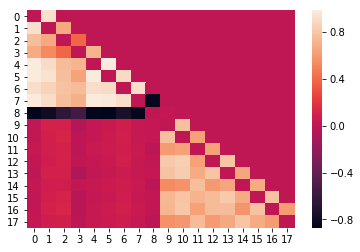

In [6]:
a = np.corrcoef(put)
a = np.tril(a, 1)
np.fill_diagonal(a, 0)

ax = sns.heatmap(a)
plt.show()

In [74]:
# Correlated indexes
idxs = np.argwhere(a > 0.7)
channels_idxs = np.unique(idxs)
channels_idxs

array([ 0,  1,  4,  5,  6,  7,  8, 10, 12, 13, 15, 16, 17])

In [76]:
m1_corr = np.array([m1[idx] for idx in channels_idxs])
m1_corr

array([[ 0.02302903,  0.00704252, -0.00194843, ..., -0.07554274,
        -0.06627009, -0.06124643],
       [ 0.02730052,  0.03037771,  0.02417247, ..., -0.06571452,
        -0.06866455, -0.06088257],
       [ 0.00947498,  0.01963298,  0.0104777 , ..., -0.0650751 ,
        -0.07021949, -0.06769089],
       ...,
       [ 0.01017695,  0.01693062,  0.01809825, ...,  0.01151707,
         0.0289917 ,  0.01881475],
       [ 0.00306702,  0.00816345,  0.02119446, ...,  0.03813171,
         0.02662659,  0.02368164],
       [-0.01323155, -0.03594535, -0.03607614, ...,  0.00407628,
        -0.01565116, -0.00797817]])

In [77]:
mean_signal = sum(m1_corr)*1000
mean_signal

array([ -60.14858351,  -43.33076127,  -80.09521489, ..., -263.49080112,
       -220.13428331, -240.30389455])

/home/yu/venvs/dsp/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


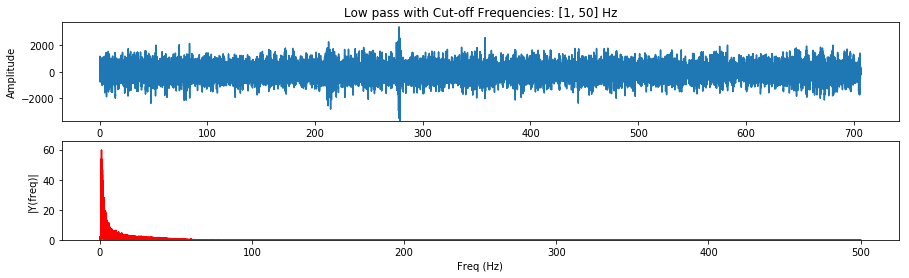

In [80]:
fs = 1000
seconds = len(mean_signal)/fs
t = np.arange(0, seconds, 1.0/fs)
filter_order = 5

# Cut-off frequencies
fcs = [1, 50]

w = [fc/(fs / 2) for fc in fcs] # Normalize the frequency
b, a = signal.butter(filter_order, w, 'bandpass')
output = signal.filtfilt(b, a, mean_signal)
x = plot_fft(output, f'Low pass with Cut-off Frequencies: {fcs} Hz')